# Demostración de la API Python de jpegexp-rs

Este notebook muestra cómo utilizar la API FFI de jpegexp-rs desde Python para codificar y decodificar imágenes JPEG/JPEG2000. Incluye ejemplos de uso, manejo de errores y comparación con bibliotecas estándar.

---

## Requisitos

- Tener compilado el binario `jpegexp_rs.dll` en la carpeta `target/release` o `target/debug`.
- Instalar las siguientes librerías de Python:
    - numpy
    - matplotlib
    - pillow

Puedes instalar los paquetes ejecutando:

```bash
pip install numpy matplotlib pillow
```


In [1]:
# Instalación de dependencias (ejecuta solo si es necesario)
!pip install numpy matplotlib pillow

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Función para generar un gradiente de prueba

def generate_gradient(width, height):
    arr = np.linspace(0, 255, width, dtype=np.uint8)
    grad = np.tile(arr, (height, 1))
    return grad

In [4]:
# --- FFI Wrapper para jpegexp-rs ---
import ctypes
from ctypes import POINTER, c_void_p, c_int, c_uint32, c_size_t, c_ubyte

# Buscar DLL
possible_dlls = [
    os.path.join("..", "target", "release", "jpegexp_rs.dll"),
    os.path.join("target", "release", "jpegexp_rs.dll"),
    os.path.join("..", "target", "debug", "jpegexp_rs.dll")
]
DLL_PATH = None
for p in possible_dlls:
    if os.path.exists(p):
        DLL_PATH = os.path.abspath(p)
        break
if DLL_PATH:
    print(f"Usando DLL: {DLL_PATH}")
else:
    print("ADVERTENCIA: No se encontró DLL. Las pruebas FFI fallarán.")

class JpegExpFFI:
    def __init__(self, dll_path):
        if not os.path.exists(dll_path):
            raise RuntimeError(f"DLL no encontrada en {dll_path}")
        self.lib = ctypes.CDLL(dll_path)
        # Tipos
        self.lib.jpegexp_decoder_new.argtypes = [POINTER(c_ubyte), c_size_t]
        self.lib.jpegexp_decoder_new.restype = c_void_p
        self.lib.jpegexp_decoder_free.argtypes = [c_void_p]
        self.lib.jpegexp_decoder_free.restype = None
        class ImageInfo(ctypes.Structure):
            _fields_ = [("width", c_uint32),
                        ("height", c_uint32),
                        ("components", c_uint32),
                        ("bits_per_sample", c_uint32)]
        self.lib.jpegexp_decoder_read_header.argtypes = [c_void_p, POINTER(ImageInfo)]
        self.lib.jpegexp_decoder_read_header.restype = c_int
        self.lib.jpegexp_decoder_decode.argtypes = [c_void_p, POINTER(c_ubyte), c_size_t]
        self.lib.jpegexp_decoder_decode.restype = c_int
        self.lib.jpegexp_encode_jpeg.argtypes = [
            POINTER(c_ubyte), c_uint32, c_uint32, c_uint32,
            POINTER(c_ubyte), c_size_t, POINTER(c_size_t)
        ]
        self.lib.jpegexp_encode_jpeg.restype = c_int
        self.lib.jpegexp_encode_jpegls.argtypes = [
            POINTER(c_ubyte), c_uint32, c_uint32, c_uint32,
            POINTER(c_ubyte), c_size_t, POINTER(c_size_t)
        ]
        self.lib.jpegexp_encode_jpegls.restype = c_int
        self.ImageInfo = ImageInfo
    def decode(self, data):
        data_bytes = (c_ubyte * len(data)).from_buffer_copy(data)
        decoder = self.lib.jpegexp_decoder_new(data_bytes, len(data))
        if not decoder:
            raise RuntimeError("No se pudo crear el decodificador")
        try:
            info = self.ImageInfo()
            res = self.lib.jpegexp_decoder_read_header(decoder, ctypes.byref(info))
            if res != 0:
                raise RuntimeError(f"Fallo al leer cabecera: {res}")
            required_size = info.width * info.height * info.components
            output = (c_ubyte * required_size)()
            res = self.lib.jpegexp_decoder_decode(decoder, output, required_size)
            if res != 0:
                 raise RuntimeError(f"Fallo al decodificar: {res}")
            return bytes(output), info.width, info.height, info.components
        finally:
             self.lib.jpegexp_decoder_free(decoder)
    def encode_jpeg(self, pixels, width, height, components):
         pixel_bytes = (c_ubyte * len(pixels)).from_buffer_copy(pixels)
         out_size = len(pixels) * 2 + 1024
         output = (c_ubyte * out_size)()
         written = c_size_t(0)
         res = self.lib.jpegexp_encode_jpeg(
             pixel_bytes, width, height, components,
             output, out_size, ctypes.byref(written)
         )
         if res != 0:
             raise RuntimeError(f"Fallo al codificar JPEG: {res}")
         return bytes(output[:written.value])

Usando DLL: c:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp_rs.dll


## Ejemplo: Codificación y decodificación de un gradiente

A continuación se muestra cómo codificar una imagen de gradiente en JPEG usando la API FFI y luego decodificarla nuevamente.

Inicializando FFI...
Codificando gradiente en JPEG...
JPEG codificado: 2128 bytes.
Pillow abrió JPEG: (256, 256) L


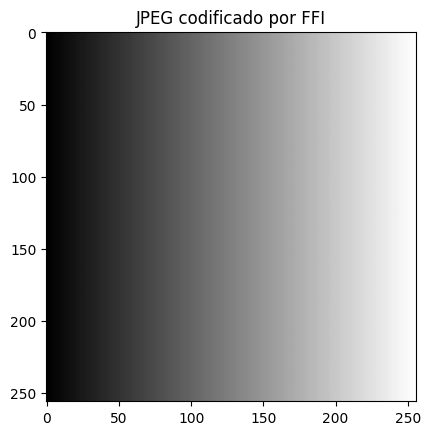

Decodificando JPEG...
Decodificado: 256x256, 1 componentes.


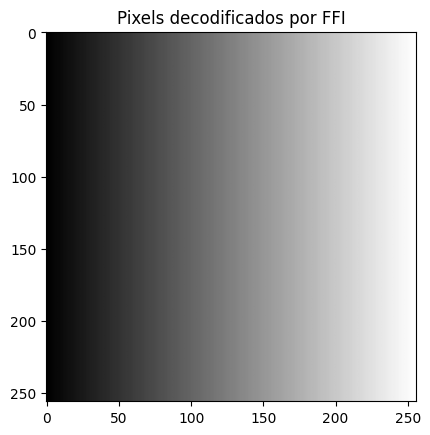

In [5]:
# --- Demostración Directa de la API FFI ---
if DLL_PATH:
    try:
        print("Inicializando FFI...")
        ffi = JpegExpFFI(DLL_PATH)
        # Codificar gradiente
        print("Codificando gradiente en JPEG...")
        w, h = 256, 256
        grad = generate_gradient(w, h)
        grad_bytes = grad.tobytes()
        encoded_jpeg_bytes = ffi.encode_jpeg(grad_bytes, w, h, 1)
        print(f"JPEG codificado: {len(encoded_jpeg_bytes)} bytes.")
        # Verificar con Pillow
        from io import BytesIO
        img = Image.open(BytesIO(encoded_jpeg_bytes))
        print(f"Pillow abrió JPEG: {img.size} {img.mode}")
        plt.imshow(img, cmap='gray')
        plt.title("JPEG codificado por FFI")
        plt.show()
        # Decodificar usando FFI
        print("Decodificando JPEG...")
        decoded_pixels, dw, dh, dc = ffi.decode(encoded_jpeg_bytes)
        print(f"Decodificado: {dw}x{dh}, {dc} componentes.")
        dec_arr = np.frombuffer(decoded_pixels, dtype=np.uint8).reshape((dh, dw))
        plt.imshow(dec_arr, cmap='gray')
        plt.title("Pixels decodificados por FFI")
        plt.show()
    except Exception as e:
        print(f"Error en la demo FFI: {e}")
else:
    print("Saltando demo FFI (DLL no encontrada)")

## Manejo de errores y casos especiales

La API FFI puede lanzar excepciones si la DLL no está disponible, si los datos son corruptos o si hay errores internos. Se recomienda envolver las llamadas en bloques `try/except` y validar los datos antes de procesarlos.

## Comparación con bibliotecas estándar

Puedes comparar los resultados de la decodificación con otras bibliotecas como `imagecodecs` o `Pillow` para validar la calidad y compatibilidad de los datos decodificados.

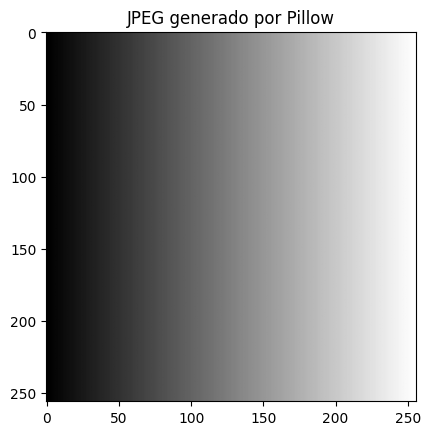

In [6]:
# Ejemplo de comparación con Pillow
img_pillow = Image.fromarray(generate_gradient(256, 256))
img_pillow.save("grad_pillow.jpg", format="JPEG")
img_loaded = Image.open("grad_pillow.jpg")
plt.imshow(img_loaded, cmap='gray')
plt.title("JPEG generado por Pillow")
plt.show()